<a href="https://colab.research.google.com/github/henriqueburis/SAM_FINETune/blob/main/segment_anything_finetune_cocofile_otimizado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/facebookresearch/segment-anything.git
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

Cloning into 'segment-anything'...
remote: Enumerating objects: 295, done.
remote: Counting objects: 100% (215/215), done.
remote: Compressing objects: 100% (96/96), done.
remote: Total 295 (delta 141), reused 121 (delta 119), pack-reused 80
Receiving objects: 100% (295/295), 18.31 MiB | 18.15 MiB/s, done.
Resolving deltas: 100% (151/151), done.
--2023-06-09 12:34:57--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 108.157.162.83, 108.157.162.120, 108.157.162.108, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|108.157.162.83|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 375042383 (358M) [binary/octet-stream]
Saving to: ‘sam_vit_b_01ec64.pth’

sam_vit_b_01ec64.pt 100%[===================>] 357.67M   134MB/s    in 2.7s    

2023-06-09 12:35:00 (134 MB/s) - ‘sam_vit_b_01ec64.pth’ saved [375042383/375042383]



In [ ]:
!unzip /content/drive/MyDrive/dataset_SAM/images_train_ANA2019_v1-20230504T162207Z-001.zip

In [ ]:
!pip install rasterio
#!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 58.1 MB/s eta 0:00:00


In [ ]:
import os
os.chdir('/content/segment-anything')

In [ ]:
### Defealt ###
from pathlib import Path
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import json

### Utils ####
from functools import reduce
#from pycocotools.coco import COCO # https://www.neuralception.com/cocodatasetapi/
from google.colab.patches import cv2_imshow

In [ ]:
### Utils ####

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))


import numpy as np
from skimage import measure

def bbox__(mask):
  threshold = 0.0 # valor de limiar (opcional)
  binary_mask = (mask > threshold).astype(np.uint8)
  labels = measure.label(binary_mask)

  bbox_list = []
  for region in measure.regionprops(labels):
       bbox = region.bbox # retorna (min_row, min_col, max_row, max_col)
       bbox_list.append(bbox)
  input_box = np.array(bbox_list[0])

  return input_box, binary_mask


def generate_mask_bbox(poly):
    poly = list(map(round, poly))
    poly = reduce(lambda a, b: a + [[b[0], b[1]]], [(poly[i], poly[i+1]) for i in range(0, len(poly), 2)], [])
    poly = np.array(poly)
    bbox = np.array([np.min(poly[:, 0]), np.min(poly[:, 1]), np.max(poly[:, 0]), np.max(poly[:, 1])])
    norm_poly = poly - bbox[0:2]
    size = [np.max(norm_poly[:, 0]), np.max(norm_poly[:, 1])]
    img = np.zeros((size[0], size[1]), dtype=np.uint8)
    cv2.fillPoly(img, [norm_poly], color=(255, 255, 255))
    mask = (img != 0)
    return mask, bbox


def generate_whole_mask(mask, bbox, img_height, img_width):
    whole_mask = np.zeros((img_width,img_height), dtype=bool)
    whole_mask[bbox[0]:bbox[2], bbox[1]:bbox[3]] = mask

    return whole_mask.T

In [ ]:
### Nosso cocorlt_file de leitura ###

with open('/content/images_train_ANA2019_v1/train.json') as f:
    data = json.load(f)

images_ = {}
bbox_coords = {}
ground_truth_masks = {}

for value in data.get('images'):
  imgfile = value['file_name'] ### output 10007_mosaic.tif, 10149_mosaic.tif .....
  image = cv2.imread(f'/content/images_train_ANA2019_v1/{imgfile}') ### output [] matriz da img (572, 502, 3)
  images_[value['id']] = imgfile, image.shape[0], image.shape[1] ### output {0: ('10007_mosaic.tif', 572, 502), 1:

print(images_)


for value in data.get('annotations'):
      try:
        id = value['id'] ### output 0,1,3,4....
        mask, bbox = generate_mask_bbox(np.array(value['segmentation'][0])) ### input array segmentation [403.0, 84.5, 408.0, 82.5, .......... 384.5, 76.0, 391.0, 82.5, 403.0, 84.5] ///
        whole_mask = generate_whole_mask(mask, bbox, images_[value['image_id']][1], images_[value['image_id']][2])
        img_name = images_[value['image_id']][0].replace(".tif", "")
        ground_truth_masks[id] = img_name , whole_mask
        bbox_coords[id] = img_name ,np.array(bbox)
        #if(id==750):
          #break
      except:
        pass

print(bbox_coords)

{0: ('10007_mosaic.tif', 572, 502), 1: ('10149_mosaic.tif', 513, 502), 2: ('10155_mosaic.tif', 515, 502), 3: ('10270_mosaic.tif', 571, 502), 4: ('10271_mosaic.tif', 572, 502), 5: ('10272_mosaic.tif', 572, 502), 6: ('10276_mosaic.tif', 576, 502), 7: ('10278_mosaic.tif', 577, 502), 8: ('10534_mosaic.tif', 571, 502), 9: ('10681_mosaic.tif', 514, 502), 10: ('10683_mosaic.tif', 515, 502), 11: ('10751_mosaic.tif', 542, 502), 12: ('10753_mosaic.tif', 543, 502), 13: ('10802_mosaic.tif', 574, 502), 14: ('10942_mosaic.tif', 514, 502), 15: ('10944_mosaic.tif', 514, 502), 16: ('11015_mosaic.tif', 542, 502), 17: ('11016_mosaic.tif', 542, 502), 18: ('11060_mosaic.tif', 570, 502), 19: ('11211_mosaic.tif', 515, 502), 20: ('11325_mosaic.tif', 570, 502), 21: ('11589_mosaic.tif', 570, 502), 22: ('11854_mosaic.tif', 571, 501), 23: ('11853_mosaic.tif', 570, 501), 24: ('11855_mosaic.tif', 572, 501), 25: ('12117_mosaic.tif', 570, 502), 26: ('12118_mosaic.tif', 571, 502), 27: ('12381_mosaic.tif', 570, 502), 2

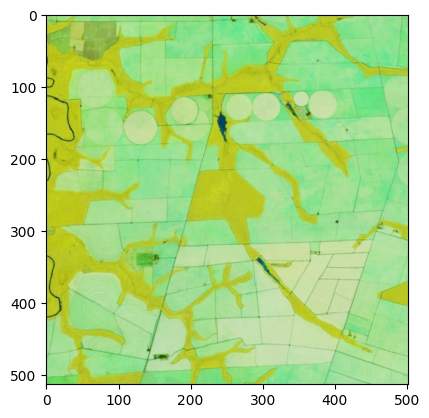

In [ ]:
# Abra o arquivo TIF
with rasterio.open('/content/images_train_ANA2019_v1/10149_mosaic.tif') as src:
    if src.count == 4 and 'alpha' in src.tags():
        alpha = src.read(4)
        with rasterio.open('mascara.png', 'w', driver='PNG', width=src.width, height=src.height, count=1, dtype=rasterio.uint8) as dst:
            dst.write(alpha, 1)

    img = src.read([1, 2, 3])
    img = img.transpose(1, 2, 0)
    plt.imshow(img)

In [ ]:
print(bbox_coords)

{0: ('10007_mosaic', array([382,  52, 416,  84])), 1: ('10007_mosaic', array([366, 154, 410, 198])), 2: ('10007_mosaic', array([354,  82, 412, 140])), 3: ('10007_mosaic', array([340, 138, 370, 166])), 4: ('10007_mosaic', array([316, 112, 346, 144])), 5: ('10007_mosaic', array([334, 168, 366, 200])), 6: ('10007_mosaic', array([348, 190, 380, 224])), 7: ('10007_mosaic', array([398, 124, 438, 166])), 9: ('10007_mosaic', array([326, 352, 358, 384])), 10: ('10007_mosaic', array([300, 328, 332, 360])), 11: ('10007_mosaic', array([406, 276, 432, 304])), 12: ('10007_mosaic', array([350, 312, 366, 330])), 13: ('10007_mosaic', array([368, 280, 400, 316])), 14: ('10007_mosaic', array([342, 238, 382, 282])), 15: ('10149_mosaic', array([248, 110, 284, 146])), 16: ('10149_mosaic', array([284, 108, 322, 146])), 17: ('10149_mosaic', array([362, 104, 402, 142])), 18: ('10149_mosaic', array([210, 114, 228, 134])), 19: ('10149_mosaic', array([ 42,  74,  94, 128])), 20: ('10149_mosaic', array([ 52, 128, 1

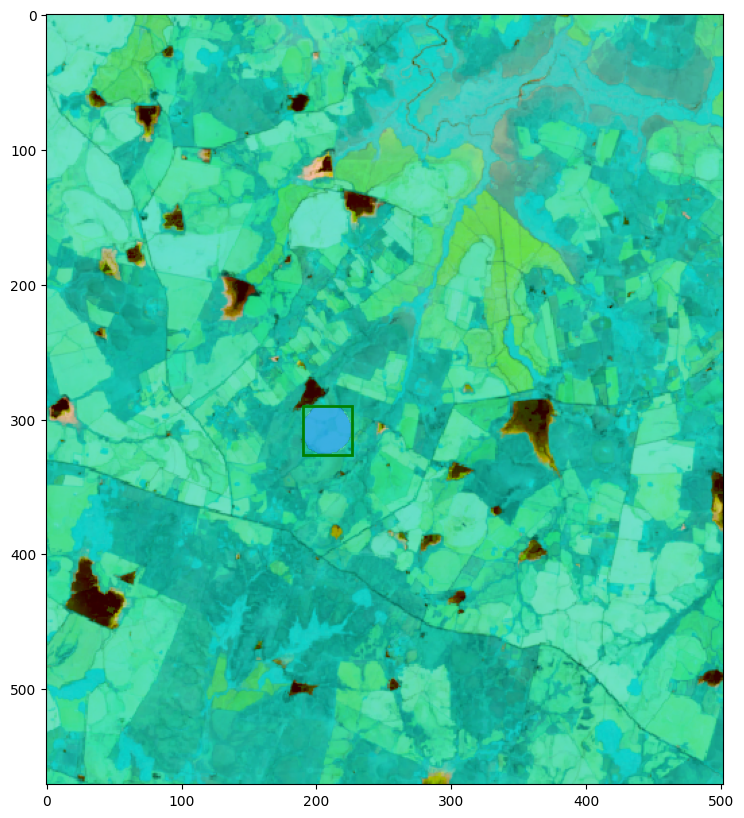

In [ ]:
key_ = 120

image = cv2.imread(f'/content/images_train_ANA2019_v1/{bbox_coords[key_][0]}.tif')

plt.figure(figsize=(10,10))
plt.imshow(image)
show_box(bbox_coords[key_][1], plt.gca())
show_mask(ground_truth_masks[key_][1], plt.gca())
plt.axis('on')
plt.show()

In [ ]:
model_type = 'vit_b'
checkpoint = '/content/sam_vit_b_01ec64.pth'

print('==> Building model..')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

from segment_anything import SamPredictor, sam_model_registry
sam_model = sam_model_registry[model_type](checkpoint=checkpoint)
sam_model.to(device)
sam_model.train();

==> Building model..
cpu


In [ ]:
# Preprocess the images
"""
from collections import defaultdict
from segment_anything.utils.transforms import ResizeLongestSide


transformed_data = defaultdict(dict)
#for k in bbox_coords.values():
for k in zip(bbox_coords.keys(), bbox_coords.values()):
  k_id, dados = k
  ##image = cv2.imread(f'/content/scans/scans/{k}.png')
  image = cv2.imread(f'/content/images_train_ANA2019_v1/{dados[0]}.tif')
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  transform = ResizeLongestSide(sam_model.image_encoder.img_size)
  input_image = transform.apply_image(image)
  input_image_torch = torch.as_tensor(input_image, device=device)
  transformed_image = input_image_torch.permute(2, 0, 1).contiguous()[None, :, :, :]

  input_image = sam_model.preprocess(transformed_image)
  original_image_size = image.shape[:2]
  input_size = tuple(transformed_image.shape[-2:])

  transformed_data[k_id]['image'] = input_image
  transformed_data[k_id]['input_size'] = input_size
  transformed_data[k_id]['original_image_size'] = original_image_size

  #break
"""

In [ ]:
from random import shuffle
# Set up the optimizer, hyperparameter tuning will improve performance here
lr = 1e-5
wd = 0
num_epochs = 100
batch_size = 32 #128 #10000
optimizer = torch.optim.Adam(sam_model.mask_decoder.parameters(), lr=lr, weight_decay=wd)

loss_fn = torch.nn.MSELoss()
#loss_fn = torch.nn.BCELoss()
keys = list(bbox_coords.keys())
shuffle(keys)

In [ ]:
def save_model(model):
    torch.save(model.state_dict(),"/content/sam_vit_b_01ec64_Ext.pth")

In [ ]:
#Teste
"""
from statistics import mean
from tqdm import tqdm
from torch.nn.functional import threshold, normalize
from segment_anything.utils.transforms import ResizeLongestSide

losses = []
init_batch = 0

for epoch in range(num_epochs):
  epoch_losses = []
  # Just train on the first 20 examples
  for k in keys[init_batch:batch_size]:
    print("id_key",k)
  init_batch = batch_size
  batch_size +=batch_size
  print("==============================")
  #break
  input("Test")
print(init_batch)
print(batch_size)

In [ ]:
#new método de train otimizado
from statistics import mean
from tqdm import tqdm
from torch.nn.functional import threshold, normalize
from segment_anything.utils.transforms import ResizeLongestSide

losses = []
init_batch = 0

for epoch in range(num_epochs):
  epoch_losses = []
  # Just train on the first 20 examples
  for k in keys[init_batch:batch_size]:
    #print("id_key",k)

    image = cv2.imread(f'/content/images_train_ANA2019_v1/{bbox_coords[k][0]}.tif')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    transform = ResizeLongestSide(sam_model.image_encoder.img_size)
    input_image_ = transform.apply_image(image)
    input_image_torch = torch.as_tensor(input_image_, device=device)
    transformed_image = input_image_torch.permute(2, 0, 1).contiguous()[None, :, :, :]

    input_image = sam_model.preprocess(transformed_image)
    original_image_size = image.shape[:2]
    input_size = tuple(transformed_image.shape[-2:])

    # No grad here as we don't want to optimise the encoders
    with torch.no_grad():
      image_embedding = sam_model.image_encoder(input_image)

      prompt_box = bbox_coords[k][1]
      box = transform.apply_boxes(prompt_box, original_image_size)
      box_torch = torch.as_tensor(box, dtype=torch.float, device=device)
      box_torch = box_torch[None, :]

      sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
          points=None,
          boxes=box_torch,
          masks=None,
      )
    low_res_masks, iou_predictions = sam_model.mask_decoder(
      image_embeddings=image_embedding,
      image_pe=sam_model.prompt_encoder.get_dense_pe(),
      sparse_prompt_embeddings=sparse_embeddings,
      dense_prompt_embeddings=dense_embeddings,
      multimask_output=False,
    )

    upscaled_masks = sam_model.postprocess_masks(low_res_masks, input_size, original_image_size).to(device)
    binary_mask = normalize(threshold(upscaled_masks, 0.0, 0))

    #print(binary_mask.shape)

    gt_mask_resized = torch.from_numpy(np.resize(ground_truth_masks[k][1], (1, 1, ground_truth_masks[k][1].shape[0], ground_truth_masks[k][1].shape[1]))).to(device)
    gt_binary_mask = torch.as_tensor(gt_mask_resized > 0, dtype=torch.float32)

    #print(gt_binary_mask.shape)

    loss = loss_fn(binary_mask, gt_binary_mask)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    epoch_losses.append(loss.item())
  losses.append(epoch_losses)
  print(f'EPOCH: {epoch}')
  print(f'Mean loss: {mean(epoch_losses)}')

  init_batch = batch_size
  batch_size +=batch_size


save_model(sam_model)

EPOCH: 0
Mean loss: 0.0006307270914476248
EPOCH: 1
Mean loss: 0.0008176296987585374
EPOCH: 2
Mean loss: 0.0007964329088281374


In [ ]:
# método original
"""
from statistics import mean

from tqdm import tqdm
from torch.nn.functional import threshold, normalize

num_epochs = 100
losses = []

for epoch in range(num_epochs):
  epoch_losses = []
  # Just train on the first 20 examples
  for k in keys[:20]:
    print("id_key",k)
    input_image = transformed_data[k]['image'].to(device)
    input_size = transformed_data[k]['input_size']
    original_image_size = transformed_data[k]['original_image_size']

    # No grad here as we don't want to optimise the encoders
    with torch.no_grad():
      image_embedding = sam_model.image_encoder(input_image)

      prompt_box = bbox_coords[k][1]
      box = transform.apply_boxes(prompt_box, original_image_size)
      box_torch = torch.as_tensor(box, dtype=torch.float, device=device)
      box_torch = box_torch[None, :]

      sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
          points=None,
          boxes=box_torch,
          masks=None,
      )
    low_res_masks, iou_predictions = sam_model.mask_decoder(
      image_embeddings=image_embedding,
      image_pe=sam_model.prompt_encoder.get_dense_pe(),
      sparse_prompt_embeddings=sparse_embeddings,
      dense_prompt_embeddings=dense_embeddings,
      multimask_output=False,
    )

    upscaled_masks = sam_model.postprocess_masks(low_res_masks, input_size, original_image_size).to(device)
    binary_mask = normalize(threshold(upscaled_masks, 0.0, 0))

    #print(binary_mask.shape)

    gt_mask_resized = torch.from_numpy(np.resize(ground_truth_masks[k][1], (1, 1, ground_truth_masks[k][1].shape[0], ground_truth_masks[k][1].shape[1]))).to(device)
    gt_binary_mask = torch.as_tensor(gt_mask_resized > 0, dtype=torch.float32)

    #print(gt_binary_mask.shape)

    loss = loss_fn(binary_mask, gt_binary_mask)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    epoch_losses.append(loss.item())
  losses.append(epoch_losses)
  print(f'EPOCH: {epoch}')
  print(f'Mean loss: {mean(epoch_losses)}')


save_model(sam_model)
"""

EPOCH: 0
Mean loss: 0.0009544307671603746
EPOCH: 1
Mean loss: 0.0009547990412102081
EPOCH: 2
Mean loss: 0.0009546048895572312
EPOCH: 3
Mean loss: 0.0009547990441205912
EPOCH: 4
Mean loss: 0.0009546449393383228
EPOCH: 5
Mean loss: 0.0009551673269015737
EPOCH: 6
Mean loss: 0.0009569086178089492
EPOCH: 7
Mean loss: 0.0009576051365002058
EPOCH: 8
Mean loss: 0.0009565203057718463
EPOCH: 9
Mean loss: 0.0009567144516040571
EPOCH: 10
Mean loss: 0.000956694431079086
EPOCH: 11
Mean loss: 0.0009569086207193323
EPOCH: 12
Mean loss: 0.000957625154114794
EPOCH: 13
Mean loss: 0.0009546649744152091
EPOCH: 14
Mean loss: 0.0009546649744152091
EPOCH: 15
Mean loss: 0.0009544908461975865
EPOCH: 16
Mean loss: 0.0009544908461975865
EPOCH: 17
Mean loss: 0.0009543167238007299
EPOCH: 18
Mean loss: 0.0009537743011605926
EPOCH: 19
Mean loss: 0.0009537743069813586
EPOCH: 20
Mean loss: 0.0009539484293782152
EPOCH: 21
Mean loss: 0.0009546510525979101
EPOCH: 22
Mean loss: 0.0009565864806063473
EPOCH: 23
Mean loss: 0.

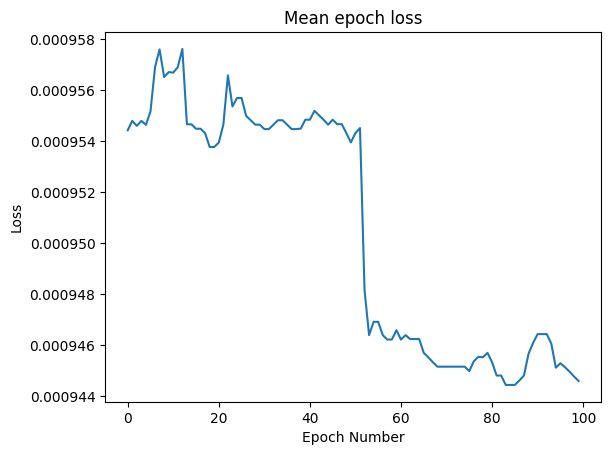

In [ ]:
mean_losses = [mean(x) for x in losses]
mean_losses

plt.plot(list(range(len(mean_losses))), mean_losses)
plt.title('Mean epoch loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')

plt.show()

In [ ]:
# Load up the model with default weights
sam_model_orig = sam_model_registry[model_type](checkpoint=checkpoint)
sam_model_orig.to(device);

In [ ]:
# Set up predictors for both tuned and original models
from segment_anything import sam_model_registry, SamPredictor
predictor_tuned = SamPredictor(sam_model)
predictor_original = SamPredictor(sam_model_orig)

In [ ]:
# The model has not seen keys[21] (or keys[20]) since we only trained on keys[:20]
k = keys[32]
print(k)

#image = cv2.imread(f'/content/scans/scans/{k}.png')
image = cv2.imread(f'/content/images_train_ANA2019_v1/{bbox_coords[k][0]}.tif')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

predictor_tuned.set_image(image)
predictor_original.set_image(image)

input_bbox = np.array(bbox_coords[k][1])

masks_tuned, _, _ = predictor_tuned.predict(
    point_coords=None,
    box=input_bbox,
    multimask_output=False,
)

masks_orig, _, _ = predictor_original.predict(
    point_coords=None,
    box=input_bbox,
    multimask_output=False,
)

34


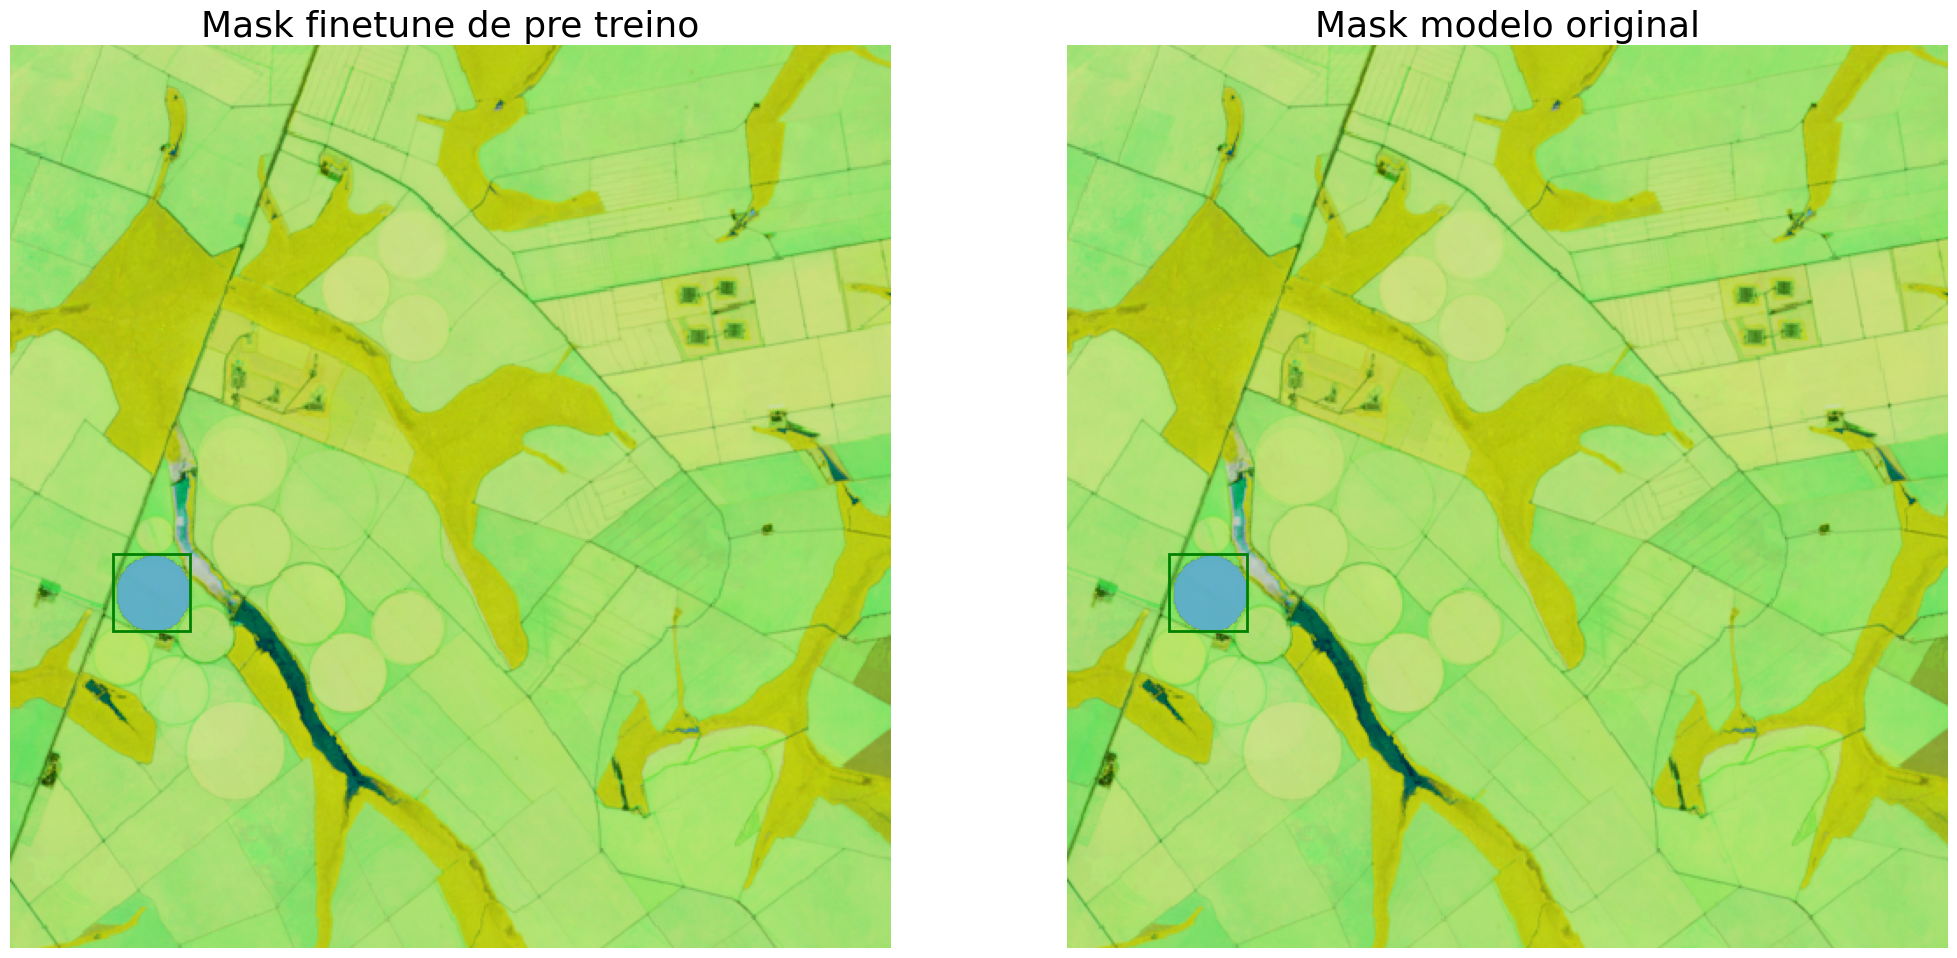

In [ ]:
_, axs = plt.subplots(1, 2, figsize=(25, 25))


axs[0].imshow(image)
show_mask(masks_tuned, axs[0])
show_box(input_bbox, axs[0])
axs[0].set_title('Mask finetune de pre treino', fontsize=26)
axs[0].axis('off')


axs[1].imshow(image)
show_mask(masks_orig, axs[1])
show_box(input_bbox, axs[1])
axs[1].set_title('Mask modelo original', fontsize=26)
axs[1].axis('off')

plt.show()